In [1]:
import pandas as pd
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
equity_list = ['A', 'B']
alpha_1 = pd.Series(index=equity_list, data=[2.4, 2.5])
alpha_2 = pd.Series(index=equity_list, data=[2.5, 2.4])
alpha_true = pd.Series(index=equity_list, data=[2.48, 2.42])
benchmark_weight = pd.Series(index=equity_list, data=[0., 0.])

sigma_A, sigma_B = 0.42, 0.33
rho_AB = 0.7
cov_mat = [
    [sigma_A ** 2, rho_AB * sigma_A * sigma_B],
    [rho_AB * sigma_A * sigma_B, sigma_B ** 2]
]
cov_df = pd.DataFrame(index=equity_list, columns=equity_list, data=cov_mat)
print(alpha_1, alpha_2, cov_df)

A    2.4
B    2.5
dtype: float64 A    2.5
B    2.4
dtype: float64          A        B
A  0.17640  0.09702
B  0.09702  0.10890


In [5]:
# alpha和cov扩展ｃａｓｈ
alpha_1['cash'] = 0.
alpha_2['cash'] = 0.
alpha_true['cash'] = 0.
cov_df = cov_df.reindex(equity_list + ['cash']).fillna(0.)
cov_df['cash'] = 0.
trading_day = '20100101'
cov_panel = pd.Panel(
    data={trading_day: cov_df})
alpha_1_df = pd.DataFrame(
    index=[trading_day],
    data=[alpha_1])
alpha_2_df = pd.DataFrame(
    index=[trading_day],
    data=[alpha_2])

# benchmark
benchmark_weight['cash'] = 0.

asset_lower_boundary_series = pd.Series(index=equity_list+['cash'], data=0.)
# asset_lower_boundary_series['cash'] = 0
asset_upper_boundary_series = pd.Series(index=equity_list+['cash'], data=1)
# asset_upper_boundary_series['cash'] = 0.

/home/casey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
from src.solver import *

In [6]:
market_value = 1.
current_price = pd.Series(index=equity_list+['cash'], data=1.)

target_risk = 0.10
target_return = 0.1


param = {
    'asset_list': equity_list,
    'alpha_series': alpha_2, # estimated alpha
    'asset_ret_cov': cov_df,
    'market_value': market_value,
    'current_price': current_price,
    'benchmark_weight_series': benchmark_weight,
    'asset_lower_boundary_series': asset_lower_boundary_series,
    'asset_upper_boundary_series': asset_upper_boundary_series,
    'target_risk': target_risk,
    'target_return': target_return,
    'solver': cvx.MOSEK,
    'cash_position': 0.2
}

In [45]:
# param['asset_lower_boundary_series']['cash'] = param['cash_position']
# param['asset_upper_boundary_series']['cash'] = param['cash_position']
# model = MaxSharpeRatioSolver(param)
# model.solve_without_round()

In [46]:
# model = MaxReturnSolver(param)
# model.solve_without_round()

In [47]:
# model = MinRiskSolver(param)
# model.solve_without_round()

In [7]:
from src.efficient_frontier import *

In [8]:
resolution = 1000

In [9]:
eff_front = EfficientFrontier(param)
eff_front.initialize()
print(eff_front.min_return, eff_front.max_return)

2.4 2.5


In [10]:
estimated_frontier_list = eff_front.get_efficient_frontier(resolution)

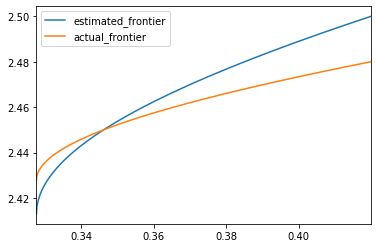

In [11]:
portfolio_list = [x['expected_weight'] for x in estimated_frontier_list]
result_list = ShowEfficientFrontier(portfolio_list, alpha_2, cov_df).show_frontier()
y = [x['exante_return'] for x in result_list]
x = [x['exante_risk'] for x in result_list]
estimated_frontier = pd.Series(index=x, data=y, name='estimated_frontier')
portfolio_list = [x['expected_weight'] for x in estimated_frontier_list]
result_list = ShowEfficientFrontier(portfolio_list, alpha_true, cov_df).show_frontier()
y = [x['exante_return'] for x in result_list]
x = [x['exante_risk'] for x in result_list]
actual_frontier = pd.Series(index=x, data=y, name='actual_frontier')

pd.concat([estimated_frontier, actual_frontier], axis=1).interpolate().plot()

In [12]:
eff_front.set_alpha_series(alpha_true)
eff_front.initialize()
print(eff_front.min_return, eff_front.max_return)

2.42 2.48


In [14]:
# eff_front.initialize()
print(eff_front.min_return, eff_front.max_return)
true_frontier_list = eff_front.get_efficient_frontier(resolution)

2.42 2.48


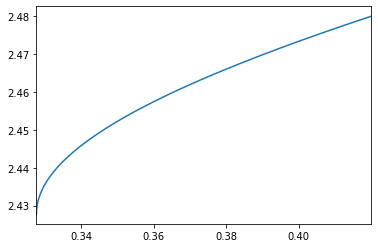

In [15]:
portfolio_list = [x['expected_weight'] for x in true_frontier_list]
result_list = ShowEfficientFrontier(portfolio_list, alpha_true, cov_df).show_frontier()
y = [x['exante_return'] for x in result_list]
x = [x['exante_risk'] for x in result_list]
true_frontier = pd.Series(index=x, data=y, name='true_frontier')
true_frontier.plot()


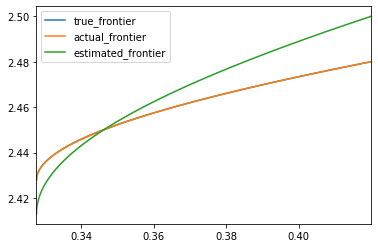

In [17]:
pd.concat([true_frontier, actual_frontier, estimated_frontier], axis=1).interpolate().plot()

# 真实的例子

In [13]:
cov_df = pd.read_csv('cov.csv', index_col=0)
alpha_df = pd.read_csv('alpha.csv', header=None, names=['sec', 'alpha'])
alpha_true = alpha_df.set_index('sec')['alpha']
equity_list = alpha_true.index.tolist()
equity_list.remove('cash')

In [14]:
data = np.random.multivariate_normal(alpha_true, cov_df, size=1000)

In [15]:
alpha_1 = pd.Series(index=equity_list+['cash'], data=data.mean(axis=0)) # estimate alpha

In [16]:
market_value = 1.
current_price = pd.Series(index=equity_list, data=1.)
resolution = 1000
param = {
    'asset_list': equity_list,
    'alpha_series': alpha_1, # estimated alpha
    'asset_ret_cov': cov_df,
    'market_value': market_value,
    'current_price': current_price,
    'solver': cvx.MOSEK
}

In [17]:
eff_front = EfficientFrontier(param)
eff_front.initialize()
print(eff_front.min_return, eff_front.max_return)

0.003068387714030045 0.10128848360846104


In [18]:
estimated_frontier_list = eff_front.get_efficient_frontier(resolution)

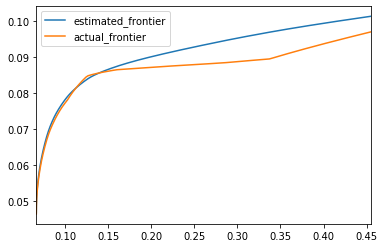

In [19]:
portfolio_list = [x['expected_weight'] for x in estimated_frontier_list]
result_list = ShowEfficientFrontier(portfolio_list, alpha_1, cov_df).show_frontier()
y = [x['exante_return'] for x in result_list]
x = [x['exante_risk'] for x in result_list]
estimated_frontier = pd.Series(index=x, data=y, name='estimated_frontier')
# estimated_frontier.plot()

portfolio_list = [x['expected_weight'] for x in estimated_frontier_list]
result_list = ShowEfficientFrontier(portfolio_list, alpha_true, cov_df).show_frontier()
y = [x['exante_return'] for x in result_list]
x = [x['exante_risk'] for x in result_list]
actual_frontier = pd.Series(index=x, data=y, name='actual_frontier')
# actual_frontier.plot()

pd.concat([estimated_frontier, actual_frontier], axis=1).interpolate().plot()

In [20]:
eff_front.set_alpha_series(alpha_true)
eff_front.initialize()
print(eff_front.min_return, eff_front.max_return)

0.0007053912345687086 0.0976302978781152


In [21]:
true_frontier_list = eff_front.get_efficient_frontier(resolution)

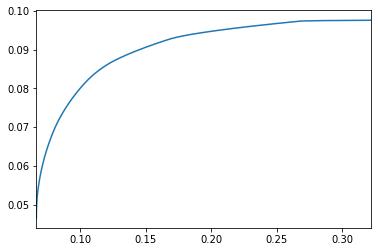

In [22]:
portfolio_list = [x['expected_weight'] for x in true_frontier_list]
result_list = ShowEfficientFrontier(portfolio_list, alpha_true, cov_df).show_frontier()
y = [x['exante_return'] for x in result_list]
x = [x['exante_risk'] for x in result_list]
true_frontier = pd.Series(index=x, data=y, name='true_frontier')
true_frontier.plot()

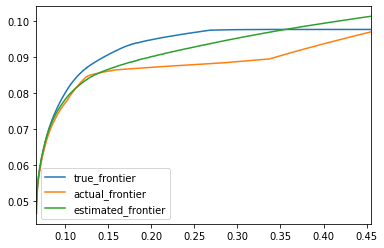

In [23]:
pd.concat([true_frontier, actual_frontier, estimated_frontier], axis=1).interpolate().plot()

In [24]:
# from src.rbo import *

In [25]:
param['alpha_series'] = alpha_1
param['kappa'] = 1
param['estimated_alpha_cov'] = param['asset_ret_cov'] / 5.
robust_eff_front = RobustEfficientFrontier(param)
robust_eff_front.initialize()
print(robust_eff_front.min_return, robust_eff_front.max_return)
# rbo = RobustMaxReturnSolver(param)
# rbo.solve_without_round()

w_tilde 002230.XSHE    0.000007
601398.XSHG    0.000005
601727.XSHG    0.000007
601958.XSHG    0.000004
601985.XSHG    0.000005
600038.XSHG    0.000007
600489.XSHG    0.000005
002415.XSHE    0.000004
601006.XSHG    0.000003
600362.XSHG    0.000004
601998.XSHG    0.000006
601601.XSHG    0.000005
601988.XSHG    0.999798
600406.XSHG    0.000007
601336.XSHG    0.000006
601318.XSHG    0.000006
600118.XSHG    0.000007
601628.XSHG    0.000005
600498.XSHG    0.000005
600111.XSHG    0.000006
601989.XSHG    0.000006
601288.XSHG    0.000006
600036.XSHG    0.000004
601939.XSHG    0.000063
000792.XSHE    0.000002
002465.XSHE    0.000007
002081.XSHE    0.000007
600522.XSHG    0.000004
cash           0.000000
dtype: float64
002230.XSHE    1.125606e-01
601398.XSHG   -8.227406e-03
601727.XSHG    4.071769e-02
601958.XSHG    1.037918e-01
601985.XSHG   -1.459226e-03
600038.XSHG    8.811959e-02
600489.XSHG    2.230380e-02
002415.XSHE    2.090733e-02
601006.XSHG    1.918930e-02
600362.XSHG    4.815649e-03
6

In [26]:
robust_estimated_frontier_list = robust_eff_front.get_efficient_frontier(resolution)

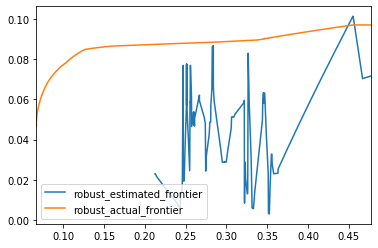

In [27]:
portfolio_list = [x['expected_weight'] for x in robust_estimated_frontier_list]
result_list = ShowEfficientFrontier(portfolio_list, alpha_1, cov_df).show_frontier()
y = [x['exante_return'] for x in result_list]
x = [x['exante_risk'] for x in result_list]
robust_estimated_frontier = pd.Series(index=x, data=y, name='robust_estimated_frontier')
# estimated_frontier.plot()

portfolio_list = [x['expected_weight'] for x in estimated_frontier_list]
result_list = ShowEfficientFrontier(portfolio_list, alpha_true, cov_df).show_frontier()
y = [x['exante_return'] for x in result_list]
x = [x['exante_risk'] for x in result_list]
robust_actual_frontier = pd.Series(index=x, data=y, name='robust_actual_frontier')
# actual_frontier.plot()

pd.concat([robust_estimated_frontier, robust_actual_frontier], axis=1).interpolate().plot()